<a href="https://colab.research.google.com/github/Huyrua27/Exercise/blob/main/Pytorch03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Ba lĩnh vực trong công nghiệp sử dụng Computer Vision hiện nay:
Y tế: Computer Vision được sử dụng trong chẩn đoán hình ảnh, phát hiện bệnh từ ảnh chụp X-quang, MRI, CT scan.
Ô tô tự lái: Các hệ thống xe tự lái sử dụng Computer Vision để nhận diện làn đường, phương tiện khác, người đi bộ và biển báo giao thông.
Sản xuất và kiểm tra chất lượng: Trong các nhà máy, Computer Vision giúp phát hiện lỗi sản phẩm, kiểm tra chất lượng hàng hóa trên dây chuyền sản xuất.

2. Định nghĩa Overfitting trong Machine Learning:
Overfitting xảy ra khi một mô hình học quá chi tiết từ dữ liệu huấn luyện, bao gồm cả nhiễu và đặc trưng không quan trọng, dẫn đến hiệu suất kém trên dữ liệu mới.

3. Ba cách để ngăn chặn Overfitting trong Machine Learning:
Sử dụng Regularization (L1, L2, Dropout): Thêm các thuật toán điều chuẩn như L1/L2 hoặc Dropout để tránh mô hình học quá mức vào dữ liệu huấn luyện.
Tăng kích thước tập dữ liệu (Data Augmentation): Tạo thêm dữ liệu mới bằng cách xoay, lật, thay đổi độ sáng của hình ảnh, giúp mô hình tổng quát hóa tốt hơn.
Sử dụng Early Stopping: Dừng quá trình huấn luyện khi độ lỗi trên tập kiểm tra bắt đầu tăng, tránh việc mô hình ghi nhớ quá nhiều chi tiết không quan trọng.



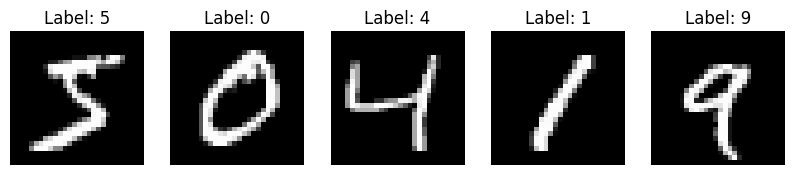

Training Time on cpu: 624.92 seconds


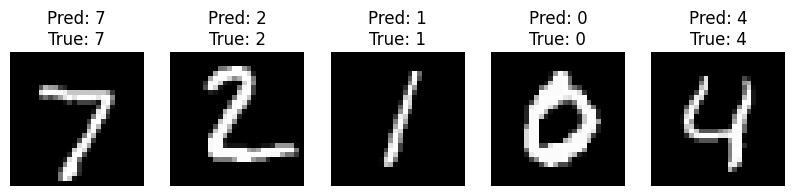

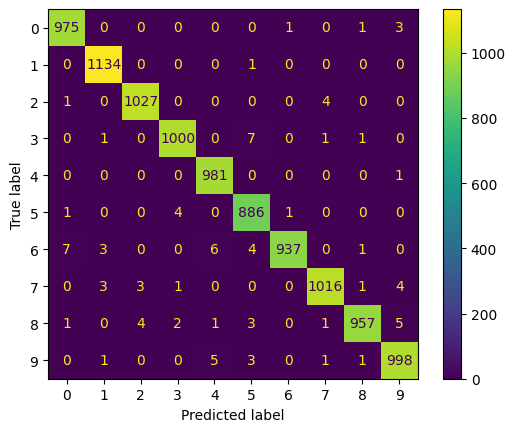

Output size (kernel=3): torch.Size([1, 16, 64, 64])
Output size (kernel=5): torch.Size([1, 16, 64, 64])
Output size (kernel=7): torch.Size([1, 16, 64, 64])


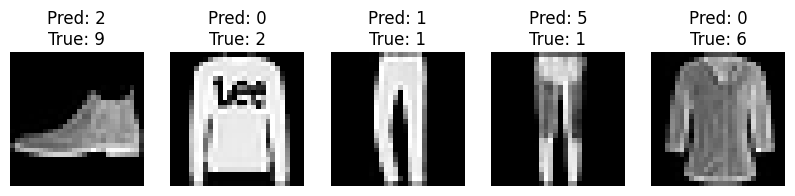

In [ ]:
# Import các thư viện cần thiết
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Tải và hiển thị dữ liệu MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# 2. Hiển thị 5 mẫu dữ liệu
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    image, label = train_dataset[i]
    axes[i].imshow(image.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')
plt.show()

# 3. Chuyển tập dữ liệu thành DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 4. Định nghĩa mô hình TinyVGG
class TinyVGG(nn.Module):
    def __init__(self):
        super(TinyVGG, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# 5. Kiểm tra hiệu suất trên CPU và GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TinyVGG().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, train_loader, device, epochs=5):
    model.train()
    start_time = time.time()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    end_time = time.time()
    print(f'Training Time on {device}: {end_time - start_time:.2f} seconds')

# Huấn luyện trên CPU
train_model(model, train_loader, "cpu", epochs=5)

# Nếu có GPU, huấn luyện trên GPU
if torch.cuda.is_available():
    model.cuda()
    train_model(model, train_loader, "cuda", epochs=5)

# 6. Dự đoán và hiển thị 5 kết quả
model.eval()
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
with torch.no_grad():
    for i in range(5):
        image, label = test_dataset[i]
        output = model(image.unsqueeze(0).to(device))
        prediction = torch.argmax(output, dim=1).item()
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Pred: {prediction}\nTrue: {label}')
        axes[i].axis('off')
plt.show()

# 7. Vẽ ma trận nhầm lẫn
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot()
plt.show()

# 8. Thử nghiệm với nn.Conv2d() với kernel_size khác nhau
conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
conv2 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
conv3 = nn.Conv2d(3, 16, kernel_size=7, padding=3)
input_tensor = torch.randn(1, 3, 64, 64)
print(f'Output size (kernel=3): {conv1(input_tensor).shape}')
print(f'Output size (kernel=5): {conv2(input_tensor).shape}')
print(f'Output size (kernel=7): {conv3(input_tensor).shape}')

# 9. Áp dụng mô hình TinyVGG trên FashionMNIST
fashion_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
fashion_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

fashion_loader = DataLoader(fashion_test, batch_size=batch_size, shuffle=False)
model.eval()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
with torch.no_grad():
    for i in range(5):
        image, label = fashion_test[i]
        output = model(image.unsqueeze(0).to(device))
        prediction = torch.argmax(output, dim=1).item()
        axes[i].imshow(image.squeeze(), cmap='gray')
        axes[i].set_title(f'Pred: {prediction}\nTrue: {label}')
        axes[i].axis('off')
plt.show()
